# <FONT size="10pt"> <center>Projet 4</center></FONT>


### Notebook 3


#### <FONT size="10pt"> <center>Target : TotalGHGEmissions</center></FONT>

#### <FONT size="10pt"> <center>Anticipez les besoins en consommation de bâtiments</center></FONT>


Vous travaillez pour la ville de **Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à **la consommation et aux émissions des bâtiments non destinés à l’habitation**.

Des relevés minutieux ont été effectués par les agents de la ville en **2016**. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de **prédire les émissions de CO2** et la **consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur **les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)**

Vous cherchez également à évaluer l’intérêt de **l’"ENERGY STAR Score"** pour la prédiction d’émissions (expliqué sur ce site en anglais : www.energystar.gov), qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- **Réaliser une courte analyse exploratoire.**
- **Tester différents modèles de prédiction afin de répondre au mieux à la problématique.**

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (**normalisation, passage au log, etc.**).

Mets en place une évaluation rigoureuse des performances, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée. Tu testeras au minimum 4 algorithmes de famille différente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

### Livrables

- Un notebook de l'analyse exploratoire mis au propre et annoté.
- Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
- Un support de présentation pour la soutenance (entre 15 et 25 slides).

## IMPORTATION DES LIBRAIRIES ET DES DONNEES

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn import dummy
from sklearn.dummy import DummyRegressor
from scipy import stats
#from regressors import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from PIL import Image
import timeit
import math
import statsmodels.api as sm
from simple_colors import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

pd.set_option('mode.chained_assignment', None) # Pour éviter la survenue de messages d'erreur lors de la création
                                                 # d'un nouveau dataframe à partir d'un existant

from warnings import filterwarnings
filterwarnings('ignore')  # code optionnel

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [50]:
# Commençons par regarder les données :

data = pd.read_csv('2016_Building_Energy_Benchmarking_Cleaned_1.csv')
data.head()

,BuildingType,PrimaryPropertyType,YearBuiltDec,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Parking (%),SteamUse_binary,Electricity_binary,NaturalGas_binary,PropertyGFABuilding (%),nonresidential,nonresidential cos,sps-district k-12,campus,hotel,other,mixed use property,university,small- and mid-sized office,self-storage facility,k-12 school,large office,senior care community,medical office,retail store,warehouse,distribution center,worship facility,supermarket / grocery store,laboratory,refrigerated warehouse,restaurant
0,NonResidential,Hotel,1920,1927,1,12,88434,60.0,84.300003,7226362.5,2003882.00,3946027.0,1276453.0,249.98,0.000000,1,1,1,1.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NonResidential,Hotel,1990,1996,1,11,103566,61.0,97.900002,8387933.0,0.00,3242851.0,5145082.0,295.86,0.145453,0,1,1,0.854547,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NonResidential,Hotel,1920,1926,1,10,61320,56.0,113.300003,6794584.0,2214446.25,2768924.0,1811213.0,286.43,0.000000,1,1,1,1.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NonResidential,Hotel,1980,1980,1,18,175580,75.0,118.699997,14172606.0,0.00,5368607.0,8803998.0,505.01,0.353115,0,1,1,0.646885,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Nonresidential COS,Other,1990,1999,1,2,97288,NaN,141.600006,12086616.0,0.00,7371434.0,4715182.0,301.81,0.382349,0,1,1,0.617651,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [51]:
data.shape

(1452, 41)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BuildingType                 1452 non-null   object 
 1   PrimaryPropertyType          1452 non-null   object 
 2   YearBuiltDec                 1452 non-null   int64  
 3   YearBuilt                    1452 non-null   int64  
 4   NumberofBuildings            1452 non-null   int64  
 5   NumberofFloors               1452 non-null   int64  
 6   PropertyGFATotal             1452 non-null   int64  
 7   ENERGYSTARScore              937 non-null    float64
 8   SiteEUIWN(kBtu/sf)           1452 non-null   float64
 9   SiteEnergyUse(kBtu)          1452 non-null   float64
 10  SteamUse(kBtu)               1452 non-null   float64
 11  Electricity(kBtu)            1452 non-null   float64
 12  NaturalGas(kBtu)             1452 non-null   float64
 13  TotalGHGEmissions 

## Analyse en apprentissage automatique (ML) des données en excluant la variable NRJ Star Score.

### Modification de certaines colonnes

In [53]:
# Création d'une copie du DataFrame original pour les modifications
Data_Final = data.copy()

# Suppression des colonnes redondantes ou non nécessaires
del Data_Final['YearBuiltDec']  # redondant avec les années par décennies
del Data_Final['PrimaryPropertyType']  # redondante avec les variables par bâtiments
del Data_Final['BuildingType']  # redondante avec les variables par bâtiments

# Recherche des variables qualitatives nécessitant une transformation
qualitative_vars = Data_Final.select_dtypes(include='object').columns.values
print('Les variables qualitatives à transformer sont :', ', '.join(qualitative_vars))
print()

Les variables qualitatives à transformer sont : 



- **Les variables qualitatives ont été deja transformées avec OneHotEncoder**

## Création des ensembles d'entraînement (train) et de test (test)

In [54]:
from sklearn.preprocessing import StandardScaler

# Sélectionner les colonnes à scaler
columns_to_scale = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", 
                    "PropertyGFABuilding (%)", "Parking (%)"]
                    
# Créer un objet StandardScaler
scaler = StandardScaler()

# Scaler les colonnes sélectionnées
data_scaled = Data_Final.copy()  # Copie du DataFrame original pour éviter de modifier les données d'origine
data_scaled[columns_to_scale] = scaler.fit_transform(data_scaled[columns_to_scale])

# Afficher les premières lignes du DataFrame avec les colonnes scalées
data_scaled.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Parking (%),SteamUse_binary,Electricity_binary,NaturalGas_binary,PropertyGFABuilding (%),nonresidential,nonresidential cos,sps-district k-12,campus,hotel,other,mixed use property,university,small- and mid-sized office,self-storage facility,k-12 school,large office,senior care community,medical office,retail store,warehouse,distribution center,worship facility,supermarket / grocery store,laboratory,refrigerated warehouse,restaurant
0,-1.039092,-0.113995,1.539488,-0.025783,60.0,84.300003,7226362.5,2003882.00,3946027.0,1276453.0,249.98,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.067350,-0.113995,1.351645,0.093915,61.0,97.900002,8387933.0,0.00,3242851.0,5145082.0,295.86,0.563872,0,1,1,-0.563872,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.069620,-0.113995,1.163801,-0.240264,56.0,113.300003,6794584.0,2214446.25,2768924.0,1811213.0,286.43,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.578899,-0.113995,2.666549,0.663568,75.0,118.699997,14172606.0,0.00,5368607.0,8803998.0,505.01,2.004730,0,1,1,-2.004730,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.158934,-0.113995,-0.338946,0.044254,NaN,141.600006,12086616.0,0.00,7371434.0,4715182.0,301.81,2.207569,0,1,1,-2.207569,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [55]:
# Colonnes à transformer
variables_a_transformer = ["TotalGHGEmissions"]

# Application de la transformation log
data_scaled[variables_a_transformer] = data_scaled[variables_a_transformer].apply(lambda x: np.log1p(x))

In [56]:
data_scaled.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Parking (%),SteamUse_binary,Electricity_binary,NaturalGas_binary,PropertyGFABuilding (%),nonresidential,nonresidential cos,sps-district k-12,campus,hotel,other,mixed use property,university,small- and mid-sized office,self-storage facility,k-12 school,large office,senior care community,medical office,retail store,warehouse,distribution center,worship facility,supermarket / grocery store,laboratory,refrigerated warehouse,restaurant
0,-1.039092,-0.113995,1.539488,-0.025783,60.0,84.300003,7226362.5,2003882.00,3946027.0,1276453.0,5.525373,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.067350,-0.113995,1.351645,0.093915,61.0,97.900002,8387933.0,0.00,3242851.0,5145082.0,5.693261,0.563872,0,1,1,-0.563872,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.069620,-0.113995,1.163801,-0.240264,56.0,113.300003,6794584.0,2214446.25,2768924.0,1811213.0,5.660979,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.578899,-0.113995,2.666549,0.663568,75.0,118.699997,14172606.0,0.00,5368607.0,8803998.0,6.226556,2.004730,0,1,1,-2.004730,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.158934,-0.113995,-0.338946,0.044254,NaN,141.600006,12086616.0,0.00,7371434.0,4715182.0,5.713106,2.207569,0,1,1,-2.207569,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [57]:
# Création des variables X et y

# créer la matrice de données
X = data_scaled[['nonresidential','nonresidential cos','sps-district k-12',
                 'campus','hotel',
                 'other','mixed use property','university',
                 'small- and mid-sized office','self-storage facility',
                 'warehouse','k-12 school','large office',
                 'senior care community','medical office',
                 'retail store','distribution center',
                 'worship facility','supermarket / grocery store',
                 'laboratory','refrigerated warehouse',"YearBuilt",
                 "NumberofBuildings","NumberofFloors", 'PropertyGFATotal', 'PropertyGFABuilding (%)', 
                 'Parking (%)', 'SteamUse_binary', 'Electricity_binary', 'NaturalGas_binary']]
                                                                     # 'PrimaryPropertyType_hospital',    
    
# créer le vecteur d'étiquettes
y = data_scaled['TotalGHGEmissions']

In [58]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y,
                                test_size=0.3, random_state = 42 # 30% des données dans le jeu de test
                                )

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1016, 30), (436, 30), (1016,), (436,))

## Prédiction à l'aide du modèle SVM (Support Vector Machine )

In [60]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def calculate_metrics(y_true, y_pred):
    RMSE = round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 2)
    Rsquared = metrics.r2_score(y_true, y_pred).round(4)
    return RMSE, Rsquared

# Définition de la grille de recherche des hyperparamètres
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'C': C_range, 'gamma': gamma_range}

# Début du chronométrage
start_time = timeit.default_timer()

# Création du modèle SVM avec GridSearchCV pour trouver les meilleurs hyperparamètres
modelSVM = GridSearchCV(svm.SVR(), param_grid, cv=5, refit=True, verbose=True).fit(X_train, y_train)

# Prédictions du modèle SVM sur les données de test et d'entraînement
y_pred_SVM_test = modelSVM.predict(X_test)
y_pred_SVM_train = modelSVM.predict(X_train)

# Calcul des métriques pour les prédictions du modèle SVM sur les données de test et d'entraînement
RMSEtest, Rsquaretest = calculate_metrics(y_test, y_pred_SVM_test)
RMSEtrain, Rsquaretrain = calculate_metrics(y_train, y_pred_SVM_train)

# Calculer le temps d'exécution
elapsed = timeit.default_timer() - start_time

# Affichage des résultats pour les données de test et d'entraînement
print("RMSE test : {:.2f}".format(RMSEtest))
print("R² test : {}".format(Rsquaretest))
print("RMSE train : {:.2f}".format(RMSEtrain))
print("R² train : {}".format(Rsquaretrain))
print()
print("Durée {:.2f}s".format(elapsed))

# Création d'un DataFrame pour les résultats du modèle SVM
df = pd.DataFrame({
    'RMSE': [f"{RMSEtest:.2f}"],
    'R²': [f"{Rsquaretest:.2f}"]
}, index=['Support Vector Machine (SVM)'])

# Affichage du DataFrame avec les résultats du modèle SVM inclus
print("\nDataFrame avec les résultats du modèle SVM inclus :")
df

Fitting 5 folds for each of 24 candidates, totalling 120 fits
RMSE test : 0.79
R² test : 0.6146
RMSE train : 0.69
R² train : 0.7233

Durée 36.44s

DataFrame avec les résultats du modèle SVM inclus :


,RMSE,R²
Support Vector Machine (SVM),0.79,0.61


## Prédiction à l'aide du modèle XGBoost (eXtreme Gradient Boosting)

In [61]:
from xgboost import XGBRegressor
import timeit

# Mesurer le temps d'exécution
start_time = timeit.default_timer()

# Définir la grille de recherche des hyperparamètres
param_grid = {'max_depth': range(2, 5), 
              'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] }  # 'n_estimators': range(2, 50),  
                                                               # plus d'estimateur, liste avec  10 estimateurs possibles

# Début du chronométrage
start_time = timeit.default_timer()

# Créer le modèle XGBoost avec GridSearchCV pour trouver les meilleurs hyperparamètres
modelXGB = GridSearchCV(XGBRegressor(), param_grid, cv=5, refit=True).fit(X_train, y_train)

# Prédire sur les données de test et d'entraînement
y_pred_XGB_test = modelXGB.predict(X_test)
y_pred_XGB_train = modelXGB.predict(X_train)

# Calculer les métriques pour les prédictions du modèle xgboost sur les données de test et d'entraînement
RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_XGB_test)), 2)
RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_XGB_train)), 2)
Rsquaretest = metrics.r2_score(y_test, y_pred_XGB_test).round(4)
Rsquaretrain = metrics.r2_score(y_train, y_pred_XGB_train).round(4)

# Calculer le temps d'exécution
elapsed = timeit.default_timer() - start_time

# Afficher les résultats
print("RMSE test : {:.2f}".format(RMSEtest))
print("R² test : {}".format(Rsquaretest))
print("RMSE train : {:.2f}".format(RMSEtrain))
print("R² train : {}".format(Rsquaretrain))
print()
print("Durée {:.2f}s".format(elapsed))

# Créer une ligne dans le DataFrame pour les résultats du modèle XGBoost
row_xgb = pd.DataFrame({
    'RMSE': [f"{RMSEtest:.2f}"],
    'R²': [f"{Rsquaretest:.2f}"]
}, index=['XGBoost'])

# Ajouter la ligne au DataFrame existant
df = pd.concat([df, row_xgb])

# Affichage du DataFrame avec les résultats du modèle XGBoost inclus
print("\nDataFrame avec les résultats du modèle XGBoost inclus :")
df

RMSE test : 0.80
R² test : 0.6054
RMSE train : 0.63
R² train : 0.7635

Durée 67.14s

DataFrame avec les résultats du modèle XGBoost inclus :


,RMSE,R²
Support Vector Machine (SVM),0.79,0.61
XGBoost,0.80,0.61


## Prédiction à l'aide du modèle Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Fonction pour calculer les métriques RMSE et R²
def calculate_metrics(y_true, y_pred):
    RMSE = round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 2)
    Rsquared = metrics.r2_score(y_true, y_pred).round(4)
    return RMSE, Rsquared

# Définition de la grille de recherche des hyperparamètres
param_grid = {
    'max_depth': range(2, 10),
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] }  # 'n_estimators': range(2, 50),  
                                                               # plus d'estimateur, liste avec  10 estimateurs possibles

# Début du chronométrage
start_time = timeit.default_timer()

# Création du modèle Random Forest avec GridSearchCV pour trouver les meilleurs hyperparamètres
modelRF = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=True).fit(X_train, y_train)

# Prédictions du modèle Random Forest sur les données de test et d'entraînement
y_pred_RF_test = modelRF.predict(X_test)
y_pred_RF_train = modelRF.predict(X_train)

# Calcul des métriques pour les prédictions du modèle Random Forest sur les données de test et d'entraînement
RMSEtest, Rsquaretest = calculate_metrics(y_test, y_pred_RF_test)
RMSEtrain, Rsquaretrain = calculate_metrics(y_train, y_pred_RF_train)

# Calculer le temps d'exécution
elapsed = timeit.default_timer() - start_time

# Affichage des résultats pour les données de test et d'entraînement
print("RMSE test : {:.2f}".format(RMSEtest))
print("R² test : {}".format(Rsquaretest))
print("RMSE train : {:.2f}".format(RMSEtrain))
print("R² train : {}".format(Rsquaretrain))
print()
print("Durée {:.2f}s".format(elapsed))

# Création d'un DataFrame pour les résultats du modèle Random Forest
row_rf = pd.DataFrame({
    'RMSE': [f"{RMSEtest:.2f}"],
    'R²': [f"{Rsquaretest:.2f}"]
}, index=['Random Forest'])

# Ajout des résultats du modèle Random Forest au DataFrame existant
df = pd.concat([df, row_rf])

# Affichage du DataFrame avec les résultats du modèle Random Forest inclus
print("\nDataFrame avec les résultats du modèle andom Forest inclus :")
df

Fitting 5 folds for each of 80 candidates, totalling 400 fits
RMSE test : 0.80
R² test : 0.6081
RMSE train : 0.55
R² train : 0.8237

Durée 390.04s

DataFrame avec les résultats du modèle andom Forest inclus :


,RMSE,R²
Support Vector Machine (SVM),0.79,0.61
XGBoost,0.80,0.61
Random Forest,0.80,0.61


## Analyse en apprentissage automatique (ML) des données avec la variable NRJ Star Score.

In [63]:
# Création d'une copie du DataFrame original pour les modifications
Data_Final_NRJ = data.copy()

# Remplacer les valeurs NaN par -1
Data_Final_NRJ = Data_Final_NRJ.fillna(-1)

# Suppression des colonnes redondantes ou non nécessaires
del Data_Final_NRJ['YearBuiltDec']  # redondant avec les années par décennies
del Data_Final_NRJ['PrimaryPropertyType']  # redondante avec les variables par bâtiments
del Data_Final_NRJ['BuildingType']  # redondante avec les variables par bâtiments

# Recherche des variables qualitatives nécessitant une transformation
qualitative_vars = Data_Final_NRJ.select_dtypes(include='object').columns.values
print('Les variables qualitatives à transformer sont :', ', '.join(qualitative_vars))
print()

Les variables qualitatives à transformer sont : 



- **Les variables qualitatives ont été deja transformées avec OneHotEncoder**

## Création des ensembles d'entraînement (train) et de test (test)

In [64]:
from sklearn.preprocessing import StandardScaler

# Sélectionner les colonnes à scaler
columns_to_scale_ = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal", 
                     "PropertyGFABuilding (%)", "Parking (%)"] 
                                                    
# Créer un objet StandardScaler
scaler = StandardScaler()

# Scaler les colonnes sélectionnées
data_scaled_2 = Data_Final_NRJ.copy()  # Copie du DataFrame original pour éviter de modifier les données d'origine
data_scaled_2[columns_to_scale_] = scaler.fit_transform(data_scaled_2[columns_to_scale_])

# Afficher les premières lignes du DataFrame avec les colonnes scalées
data_scaled_2.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Parking (%),SteamUse_binary,Electricity_binary,NaturalGas_binary,PropertyGFABuilding (%),nonresidential,nonresidential cos,sps-district k-12,campus,hotel,other,mixed use property,university,small- and mid-sized office,self-storage facility,k-12 school,large office,senior care community,medical office,retail store,warehouse,distribution center,worship facility,supermarket / grocery store,laboratory,refrigerated warehouse,restaurant
0,-1.039092,-0.113995,1.539488,-0.025783,60.0,84.300003,7226362.5,2003882.00,3946027.0,1276453.0,249.98,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.067350,-0.113995,1.351645,0.093915,61.0,97.900002,8387933.0,0.00,3242851.0,5145082.0,295.86,0.563872,0,1,1,-0.563872,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.069620,-0.113995,1.163801,-0.240264,56.0,113.300003,6794584.0,2214446.25,2768924.0,1811213.0,286.43,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.578899,-0.113995,2.666549,0.663568,75.0,118.699997,14172606.0,0.00,5368607.0,8803998.0,505.01,2.004730,0,1,1,-2.004730,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.158934,-0.113995,-0.338946,0.044254,-1.0,141.600006,12086616.0,0.00,7371434.0,4715182.0,301.81,2.207569,0,1,1,-2.207569,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [65]:
# Colonnes à transformer
variables_a_transformer_ = ["SiteEUIWN(kBtu/sf)", "ENERGYSTARScore", "TotalGHGEmissions", "SiteEnergyUse(kBtu)"]

# Application de la transformation log
data_scaled_2[variables_a_transformer_] = data_scaled_2[variables_a_transformer_].apply(lambda x: np.log1p(x))

In [66]:
data_scaled_2.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Parking (%),SteamUse_binary,Electricity_binary,NaturalGas_binary,PropertyGFABuilding (%),nonresidential,nonresidential cos,sps-district k-12,campus,hotel,other,mixed use property,university,small- and mid-sized office,self-storage facility,k-12 school,large office,senior care community,medical office,retail store,warehouse,distribution center,worship facility,supermarket / grocery store,laboratory,refrigerated warehouse,restaurant
0,-1.039092,-0.113995,1.539488,-0.025783,4.110874,4.446174,15.793246,2003882.00,3946027.0,1276453.0,5.525373,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.067350,-0.113995,1.351645,0.093915,4.127134,4.594109,15.942305,0.00,3242851.0,5145082.0,5.693261,0.563872,0,1,1,-0.563872,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.069620,-0.113995,1.163801,-0.240264,4.043051,4.738827,15.731637,2214446.25,2768924.0,1811213.0,5.660979,-0.445350,1,1,1,0.445350,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.578899,-0.113995,2.666549,0.663568,4.330733,4.784989,16.466822,0.00,5368607.0,8803998.0,6.226556,2.004730,0,1,1,-2.004730,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.158934,-0.113995,-0.338946,0.044254,-inf,4.960044,16.307609,0.00,7371434.0,4715182.0,5.713106,2.207569,0,1,1,-2.207569,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [67]:
# Création des variables X et y

# créer la matrice de données
X = data_scaled_2[['nonresidential','nonresidential cos','sps-district k-12',
                 'campus','hotel',
                 'other','mixed use property','university',
                 'small- and mid-sized office','self-storage facility',
                 'warehouse','k-12 school','large office',
                 'senior care community','medical office',
                 'retail store','distribution center',
                 'worship facility','supermarket / grocery store',
                 'laboratory','refrigerated warehouse',"YearBuilt",
                 "NumberofBuildings","NumberofFloors", 'PropertyGFATotal', 'PropertyGFABuilding (%)', 
                 'Parking (%)', 'SteamUse_binary', 'Electricity_binary', 'NaturalGas_binary', 'ENERGYSTARScore']]
                                                                     # 'PrimaryPropertyType_hospital',    
    
# créer le vecteur d'étiquettes
y = data_scaled_2['TotalGHGEmissions']

In [68]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y,
                                test_size=0.3, random_state = 42 # 30% des données dans le jeu de test
                                )

In [69]:
# X_train et y_train doivent être des DataFrame ou des arrays numpy

# Remplacer les valeurs NaN par -1
#X_train = X_train.fillna(-1)
#y_train = y_train.fillna(-1)
#X_test = X_test.fillna(-1)
#y_test = y_test.fillna(-1)

# Remplacer les valeurs infinies par un grand nombre (ou un nombre raisonnable dans votre contexte)
X_train = X_train.replace([np.inf, -np.inf], -1)
y_train = y_train.replace([np.inf, -np.inf], -1)
X_test = X_test.replace([np.inf, -np.inf], -1)
y_test = y_test.replace([np.inf, -np.inf], -1)

# Assurez-vous que toutes les valeurs sont des floats (facultatif)
#X_train = X_train.astype(np.float64)
#y_train = y_train.astype(np.float64)
#X_test = X_test.astype(np.float64)
#y_test = y_test.astype(np.float64)

In [70]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1016, 31), (436, 31), (1016,), (436,))

## Prédiction à l'aide du modèle SVM (Support Vector Machine ) avec ENERGYSTARScore

In [71]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def calculate_metrics(y_true, y_pred):
    RMSE = round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 2)
    Rsquared = metrics.r2_score(y_true, y_pred).round(4)
    return RMSE, Rsquared

# Définition de la grille de recherche des hyperparamètres
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'C': C_range, 'gamma': gamma_range}

# Début du chronométrage
start_time = timeit.default_timer()

# Création du modèle SVM avec GridSearchCV pour trouver les meilleurs hyperparamètres
modelSVM = GridSearchCV(svm.SVR(), param_grid, cv=5, refit=True, verbose=True).fit(X_train, y_train)

# Prédictions du modèle SVM sur les données de test et d'entraînement
y_pred_SVM_test = modelSVM.predict(X_test)
y_pred_SVM_train = modelSVM.predict(X_train)

# Calcul des métriques pour les prédictions du modèle SVM sur les données de test et d'entraînement
RMSEtest, Rsquaretest = calculate_metrics(y_test, y_pred_SVM_test)
RMSEtrain, Rsquaretrain = calculate_metrics(y_train, y_pred_SVM_train)

# Calculer le temps d'exécution
elapsed = timeit.default_timer() - start_time

# Affichage des résultats pour les données de test et d'entraînement
print("RMSE test : {:.2f}".format(RMSEtest))
print("R² test : {}".format(Rsquaretest))
print("RMSE train : {:.2f}".format(RMSEtrain))
print("R² train : {}".format(Rsquaretrain))
print()
print("Durée {:.2f}s".format(elapsed))

# Création d'un DataFrame pour les résultats du modèle SVM
df = pd.DataFrame({
    'RMSE': [f"{RMSEtest:.2f}"],
    'R²': [f"{Rsquaretest:.2f}"]
}, index=['Support Vector Machine (SVM)'])

# Affichage du DataFrame avec les résultats du modèle SVM inclus
print("\nDataFrame avec les résultats du modèle SVM inclus :")
df

Fitting 5 folds for each of 24 candidates, totalling 120 fits
RMSE test : 0.77
R² test : 0.636
RMSE train : 0.63
R² train : 0.7636

Durée 18.78s

DataFrame avec les résultats du modèle SVM inclus :


,RMSE,R²
Support Vector Machine (SVM),0.77,0.64


## Prédiction à l'aide du modèle XGBoost (eXtreme Gradient Boosting) avec ENERGYSTARScore

In [72]:
from xgboost import XGBRegressor
import timeit

# Mesurer le temps d'exécution
start_time = timeit.default_timer()

# Définir la grille de recherche des hyperparamètres
param_grid = {'max_depth': range(2, 5), 
              'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] }  # 'n_estimators': range(2, 50),  
                                                                                   # plus d'estimateur, liste avec  10 estimateurs possibles

# Début du chronométrage
start_time = timeit.default_timer()

# Créer le modèle XGBoost avec GridSearchCV pour trouver les meilleurs hyperparamètres
modelXGB = GridSearchCV(XGBRegressor(), param_grid, cv=5, refit=True).fit(X_train, y_train)

# Prédire sur les données de test et d'entraînement
y_pred_XGB_test = modelXGB.predict(X_test)
y_pred_XGB_train = modelXGB.predict(X_train)

# Calculer les métriques pour les prédictions du modèle xgboost sur les données de test et d'entraînement
RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_XGB_test)), 2)
RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_XGB_train)), 2)
Rsquaretest = metrics.r2_score(y_test, y_pred_XGB_test).round(4)
Rsquaretrain = metrics.r2_score(y_train, y_pred_XGB_train).round(4)

# Calculer le temps d'exécution
elapsed = timeit.default_timer() - start_time

# Afficher les résultats
print("RMSE test : {:.2f}".format(RMSEtest))
print("R² test : {}".format(Rsquaretest))
print("RMSE train : {:.2f}".format(RMSEtrain))
print("R² train : {}".format(Rsquaretrain))
print()
print("Durée {:.2f}s".format(elapsed))

# Créer une ligne dans le DataFrame pour les résultats du modèle XGBoost
row_xgb = pd.DataFrame({
    'RMSE': [f"{RMSEtest:.2f}"],
    'R²': [f"{Rsquaretest:.2f}"]
}, index=['XGBoost'])

# Ajouter la ligne au DataFrame existant
df = pd.concat([df, row_xgb])

# Affichage du DataFrame avec les résultats du modèle XGBoost inclus
print("\nDataFrame avec les résultats du modèle XGBoost inclus :")
df

RMSE test : 0.75
R² test : 0.6538
RMSE train : 0.59
R² train : 0.7972

Durée 69.63s

DataFrame avec les résultats du modèle XGBoost inclus :


,RMSE,R²
Support Vector Machine (SVM),0.77,0.64
XGBoost,0.75,0.65


## Prédiction à l'aide du modèle Random Forest avec ENERGYSTARScore

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Fonction pour calculer les métriques RMSE et R²
def calculate_metrics(y_true, y_pred):
    RMSE = round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 2)
    Rsquared = metrics.r2_score(y_true, y_pred).round(4)
    return RMSE, Rsquared

# Définition de la grille de recherche des hyperparamètres
param_grid = {
    'max_depth': range(2, 10),
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] }  # 'n_estimators': range(2, 50),  
                                                               # plus d'estimateur, liste avec  10 estimateurs possibles

# Début du chronométrage
start_time = timeit.default_timer()

# Création du modèle Random Forest avec GridSearchCV pour trouver les meilleurs hyperparamètres
modelRF = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=True).fit(X_train, y_train)

# Prédictions du modèle Random Forest sur les données de test et d'entraînement
y_pred_RF_test = modelRF.predict(X_test)
y_pred_RF_train = modelRF.predict(X_train)

# Calcul des métriques pour les prédictions du modèle Random Forest sur les données de test et d'entraînement
RMSEtest, Rsquaretest = calculate_metrics(y_test, y_pred_RF_test)
RMSEtrain, Rsquaretrain = calculate_metrics(y_train, y_pred_RF_train)

# Calculer le temps d'exécution
elapsed = timeit.default_timer() - start_time

# Affichage des résultats pour les données de test et d'entraînement
print("RMSE test : {:.2f}".format(RMSEtest))
print("R² test : {}".format(Rsquaretest))
print("RMSE train : {:.2f}".format(RMSEtrain))
print("R² train : {}".format(Rsquaretrain))
print()
print("Durée {:.2f}s".format(elapsed))

# Création d'un DataFrame pour les résultats du modèle Random Forest
row_rf = pd.DataFrame({
    'RMSE': [f"{RMSEtest:.2f}"],
    'R²': [f"{Rsquaretest:.2f}"]
}, index=['Random Forest'])

# Ajout des résultats du modèle Random Forest au DataFrame existant
df = pd.concat([df, row_rf])

# Affichage du DataFrame avec les résultats du modèle Random Forest inclus
print("\nDataFrame avec les résultats du modèle andom Forest inclus :")
df

Fitting 5 folds for each of 80 candidates, totalling 400 fits
RMSE test : 0.79
R² test : 0.6222
RMSE train : 0.51
R² train : 0.8496

Durée 414.98s

DataFrame avec les résultats du modèle andom Forest inclus :


,RMSE,R²
Support Vector Machine (SVM),0.77,0.64
XGBoost,0.75,0.65
Random Forest,0.79,0.62


## Méthodologie théorique pour l'interprétation des modèles d'apprentissage automatique avec des tests sur l'apprentissage par renforcement sur la regression lineaire (LR).

## SHAP

In [74]:
import shap
shap.initjs()

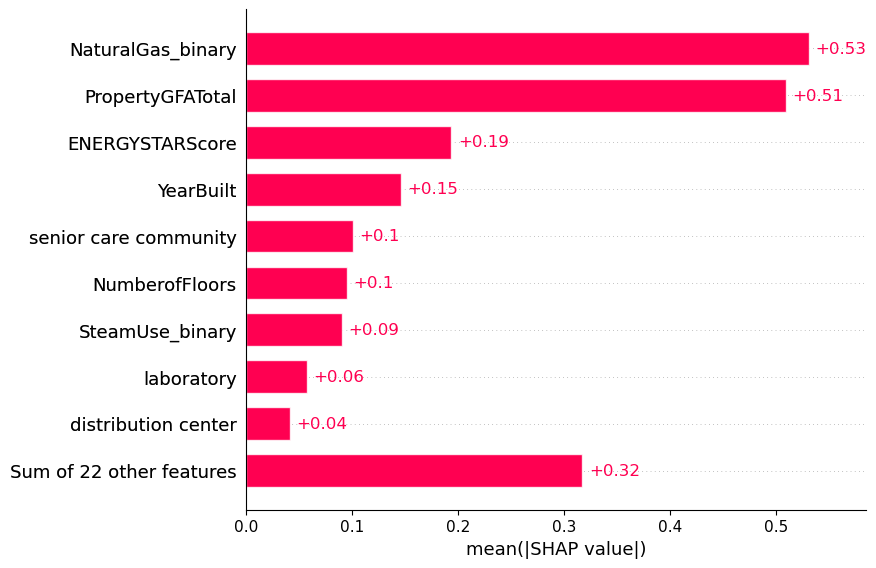

In [75]:
import xgboost as xgb

# Entraînement du modèle XGBoost avec les données d'entraînement
xgboost_model = xgb.XGBRegressor().fit(X_train, y_train)

# Création de l'explainer SHAP pour le modèle XGBoost
shap_explainer = shap.TreeExplainer(xgboost_model)

# Calcul des valeurs SHAP pour les données de test
shap_values_test = shap_explainer.shap_values(X_test)

# Création d'un DataFrame avec les valeurs SHAP pour les noms des caractéristiques
shap_values_df = pd.DataFrame(shap_values_test, columns=X_test.columns)

# Créer un objet SHAP Explanation avec les valeurs SHAP
shap_values_test = shap.Explanation(values=shap_values_df.values, 
                                    base_values=shap_explainer.expected_value, data=X_test, feature_names=X_test.columns)

# Affichage d'un graphique en barres des valeurs SHAP pour l'interprétation globale
shap.plots.bar(shap_values_test)

- **NaturalGAs (+0.53) : Cette caractéristique a la plus grande contribution positive moyenne aux prédictions du modèle. Cela signifie que, en moyenne, une augmentation de NaturalGAs conduit à une augmentation significative de la prédiction du modèle. Une valeur de +0.53 indique une contribution positive relativement forte.**


- **PropertyGFATotal (+0.51) : Cette caractéristique a une contribution positive moyenne légerement faible par rapport à NaturalGAs, mais elle reste importante. Une valeur de +0.51 indique qu'une augmentation de PropertyGFATotal entraîne également une augmentation des prédictions du modèle.**

In [76]:
# Affichage d'un graphique de force SHAP pour visualiser les contributions des caractéristiques
# shap_values : les valeurs SHAP calculées pour les données de test
# feature_names : les noms des caractéristiques dans l'ensemble de test
shap.force_plot(shap_values_test, feature_names=X_test.columns)

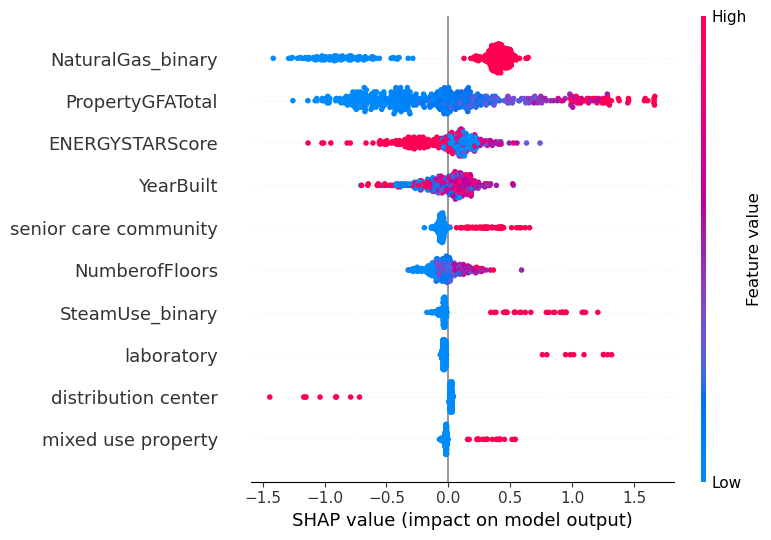

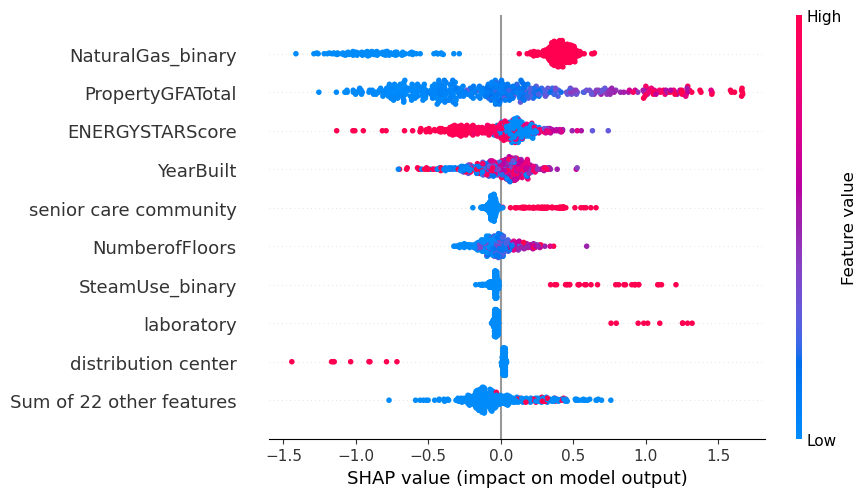

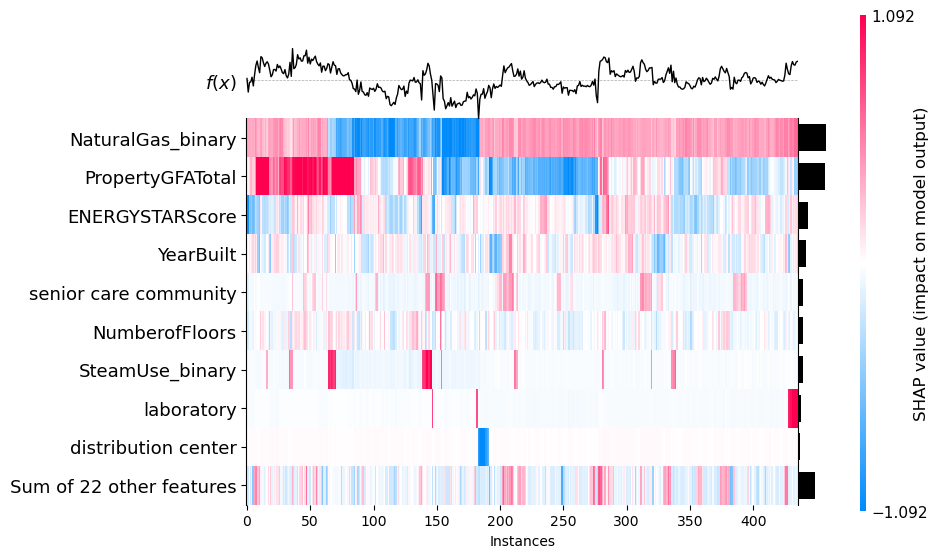

In [77]:
# Affichage du graphique de résumé SHAP pour visualiser l'importance des caractéristiques
# shap_values : les valeurs SHAP calculées pour les données de test
# X_test : l'ensemble de données de test utilisé pour la visualisation
# max_display : nombre maximum de caractéristiques à afficher
shap.summary_plot(shap_values_test, X_test, max_display=10)

# Affichage du graphique de type beeswarm SHAP pour visualiser les distributions des valeurs SHAP
# shap_values : les valeurs SHAP calculées pour les données de test
shap.plots.beeswarm(shap_values_test)

# Affichage du graphique de type heatmap SHAP pour visualiser les interactions entre les caractéristiques
# shap_values : les valeurs SHAP calculées pour les données de test
shap.plots.heatmap(shap_values_test)

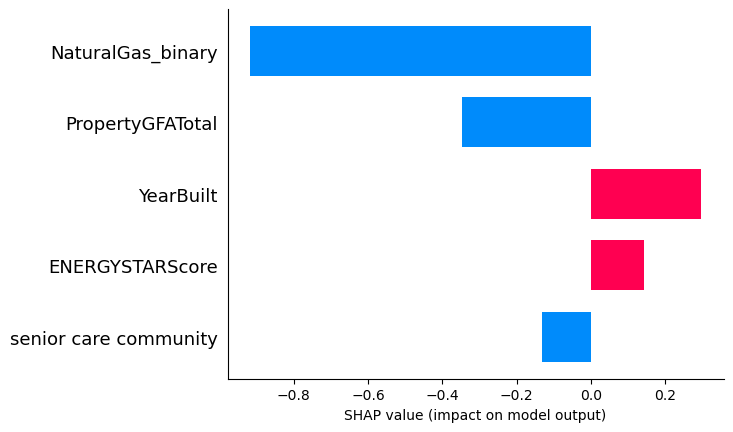

In [78]:
# Sélection du premier exemple de l'ensemble de test pour l'interprétation
sample_index = 0
sample_data = X_test.values[sample_index].reshape(1, -1)  # Reshape en 2D

# Calcul des valeurs SHAP pour l'exemple sélectionné
shap_values_sample = shap_explainer.shap_values(sample_data)

# Affichage d'un graphique à barres des valeurs SHAP pour l'exemple sélectionné
shap.bar_plot(shap_values_sample[0],  # Extraire les valeurs pour la première classe si c'est une classification
              feature_names=X_test.columns,
              max_display=5)

## LIME

In [79]:
from lime.lime_tabular import LimeTabularExplainer

In [80]:
import xgboost as xgb

# Entraîner le modèle XGBoost
xgboost_model = xgb.XGBRegressor().fit(X_train.values, y_train)

# Créer un explainer LimeTabular avec le modèle entraîné et les données d'entraînement
# - X_train.values : les données d'entraînement converties en tableau numpy
# - mode="regression" : spécifie que le modèle est utilisé pour la régression
# - feature_names : les noms des caractéristiques dans X_train
lime_explainer = LimeTabularExplainer(X_train.values, 
                                      mode="regression", 
                                      feature_names=X_train.columns
                                     )

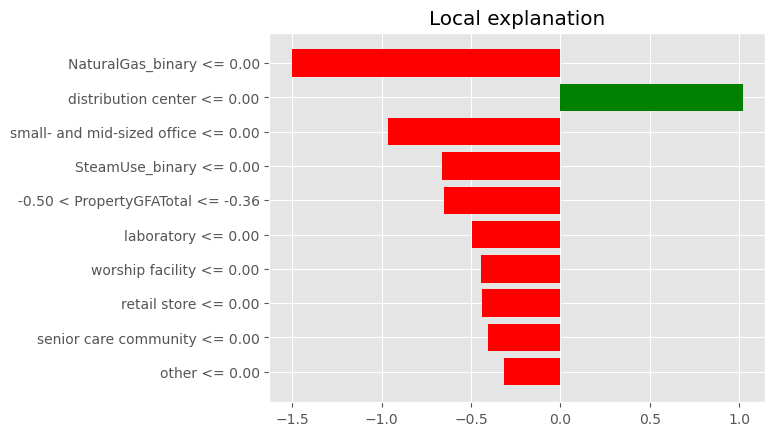

In [81]:
# Sélection du premier exemple de l'ensemble de test pour l'interprétation
sample_data = X_test.values[0]  # Caractéristiques de l'exemple sélectionné

# Explication de l'instance sélectionnée avec LIME
explanation = lime_explainer.explain_instance(sample_data, xgboost_model.predict)

# Affichage de l'explication sous forme de graphique utilisant le style "ggplot"
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()
    plt.show()

In [82]:
# Interprétation sur une seule ligne avec affichage dans le notebook
lime_explainer.explain_instance(X_test.values[0], xgboost_model.predict).show_in_notebook()